개선된 버전

In [1]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: 데이터 가져오기
ticker = "005930"  # 삼성전자
start_date = "20200101"
end_date = "20250114"

# 종가 데이터 가져오기
price_data = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)['종가']

# 외국인 보유 비중 데이터 가져오기
foreign_holding_data = stock.get_exhaustion_rates_of_foreign_investment_by_date(start_date, end_date, ticker)

# 데이터 병합
combined_data = pd.merge(price_data, foreign_holding_data[['지분율']], left_index=True, right_index=True)
combined_data.rename(columns={'지분율': 'Foreign Holding %'}, inplace=True)
combined_data.index = pd.to_datetime(combined_data.index)

# Step 2: 지분율 변화 계산
combined_data['Foreign Holding Change'] = combined_data['Foreign Holding %'].diff()

# Step 3: 통계적 유의미한 변화 판단 기준 설정
mean_change = combined_data['Foreign Holding Change'].mean()
std_change = combined_data['Foreign Holding Change'].std()

# 평균 ± 2σ 이상인 경우만 매수/매도 신호로 간주
combined_data['Action'] = np.where(
    combined_data['Foreign Holding Change'] > mean_change + 1.5 * std_change, 'Buy',
    np.where(combined_data['Foreign Holding Change'] < mean_change - 1.5 * std_change, 'Sell', 'Hold')
)

# Step 4: 매수/매도 패턴 분석
results = combined_data[combined_data['Action'].isin(['Buy', 'Sell'])]
print(results[['Foreign Holding %', 'Foreign Holding Change', 'Action']].head())



JSONDecodeError: Expecting value: line 1 column 1 (char 0)

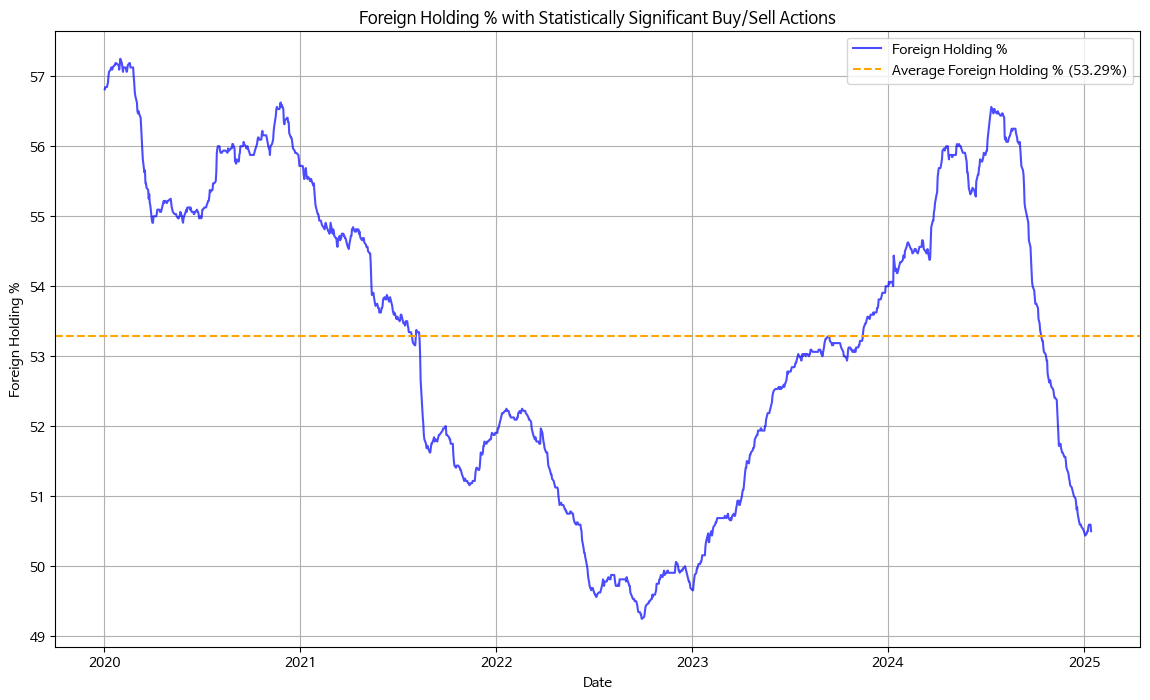

In [6]:
# Plotting updated results for statistically significant Buy/Sell actions

# Filter Buy/Sell actions only
filtered_results = combined_data[combined_data['Action'].isin(['Buy', 'Sell'])]


mian = combined_data['Foreign Holding %'].astype('float64').mean()
# Plot Buy/Sell actions on price chart
plt.figure(figsize=(14, 8))

plt.plot(combined_data.index, combined_data['Foreign Holding %'], label='Foreign Holding %', color='blue', alpha=0.7)

plt.axhline(y=mian, color='orange', linestyle='--', label=f'Average Foreign Holding % ({mian:.2f}%)')



# plt.scatter(filtered_results.index, filtered_results['Foreign Holding %'],
#             c=np.where(filtered_results['Action'] == 'Buy', 'green', 'red'), marker='o', label='Buy/Sell Points')

# Highlight Buy and Sell points
# for i, row in filtered_results.iterrows():
#     plt.text(i, row['Foreign Holding %'], row['Action'], fontsize=9, ha='center', color='black', alpha=0.7)

# Add titles and labels
plt.title('Foreign Holding % with Statistically Significant Buy/Sell Actions')
plt.xlabel('Date')
plt.ylabel('Foreign Holding %')
plt.legend()
plt.grid(True)
plt.show()


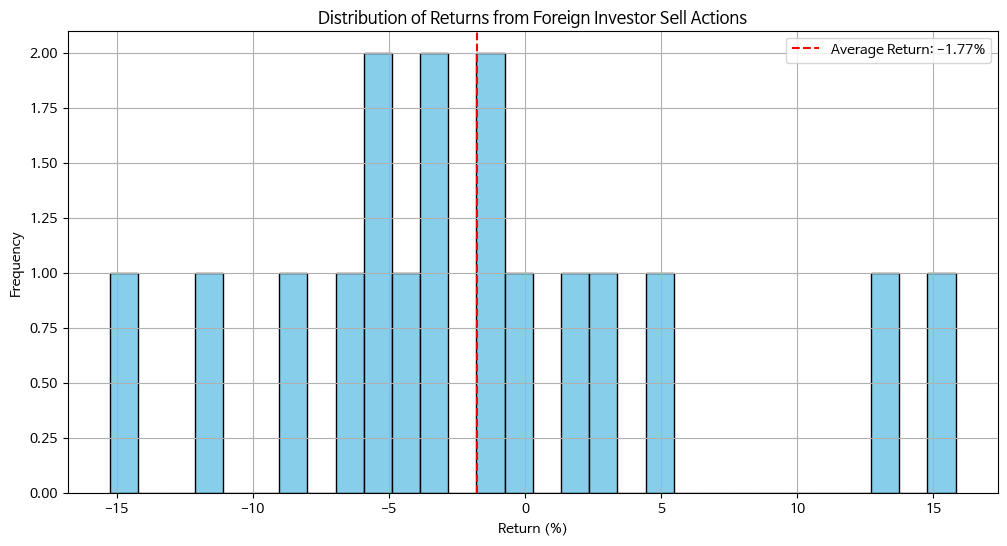

In [32]:
# Calculate returns between Buy and Sell periods
buy_price = None
holding_periods = []
returns = []
entry_dates = []
exit_dates = []

# Identify buy and sell actions and calculate returns
for date, row in filtered_results.iterrows():
    if row['Action'] == 'Buy' and buy_price is None:
        buy_price = combined_data.loc[date]['종가']
        entry_dates.append(date)
    elif row['Action'] == 'Sell' and buy_price is not None:
        sell_price = combined_data.loc[date]['종가']
        return_pct = ((sell_price - buy_price) / buy_price) * 100
        holding_period = (date - entry_dates[-1]).days
        holding_periods.append(holding_period)
        returns.append(return_pct)
        exit_dates.append(date)
        buy_price = None

# Compile results into a DataFrame
trade_results = pd.DataFrame({
    "Entry Date": entry_dates,
    "Exit Date": exit_dates,
    "Holding Period (Days)": holding_periods,
    "Return (%)": returns
})

# Plot return distribution
plt.figure(figsize=(12, 6))
plt.hist(trade_results["Return (%)"], bins=30, color='skyblue', edgecolor='black')
plt.axvline(trade_results["Return (%)"].mean(), color='red', linestyle='dashed', linewidth=1.5,
             label=f'Average Return: {trade_results["Return (%)"].mean():.2f}%')
plt.title("Distribution of Returns from Foreign Investor Sell Actions")
plt.xlabel("Return (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# Calculate average return, profit-taking threshold, and stop-loss threshold
average_return = np.mean(returns)
profit_threshold = np.percentile([r for r in returns if r > 0], 50)  # Median of positive returns (profit-taking)
loss_threshold = np.percentile([r for r in returns if r < 0], 50)    # Median of negative returns (stop-loss)

# Display thresholds
average_return, profit_threshold, loss_threshold


(-1.771485589081199, 5.128205128205128, -4.917489906298811)

진화된 버전 (최신)

In [ ]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: 데이터 가져오기
ticker = "005930"  # 삼성전자
start_date = "20200101"
end_date = "20250109"

# 종가 데이터 가져오기
price_data = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)['종가']

# 외국인 순매수 거래대금 데이터 가져오기
    # 일별 거래 데이터 가져오기
trading_data = stock.get_market_trading_value_by_date(start_date, end_date, ticker, on="순매수")
    
trading_data.rename(columns={'외국인합계': 'Net Purchase Amount'}, inplace=True)


combined_data = pd.merge(price_data, trading_data[['Net Purchase Amount']], left_index=True, right_index=True)
combined_data.index = pd.to_datetime(combined_data.index)

# Step 2: 순매수 거래대금 변화 계산
combined_data['Net Purchase Change'] = combined_data['Net Purchase Amount']
positive_mean = combined_data[combined_data['Net Purchase Change'] > 0]['Net Purchase Change'].mean()
positive_std = combined_data[combined_data['Net Purchase Change'] > 0]['Net Purchase Change'].std()
negative_mean = combined_data[combined_data['Net Purchase Change'] < 0]['Net Purchase Change'].mean()
negative_std = combined_data[combined_data['Net Purchase Change'] < 0]['Net Purchase Change'].std()

# 평균 ± 1.5σ 이상인 경우만 매수/매도 신호로 간주
combined_data['Action'] = np.where(
    combined_data['Net Purchase Change'] > positive_mean + 1.5 * positive_std, 'Buy',
    np.where(combined_data['Net Purchase Change'] < negative_mean - 1.5 * negative_std, 'Sell', 'Hold')
)

# Step 4: 매수/매도 패턴 분석
results = combined_data[combined_data['Action'].isin(['Buy', 'Sell'])]
print(results[['Net Purchase Amount', 'Net Purchase Change', 'Action']].head())


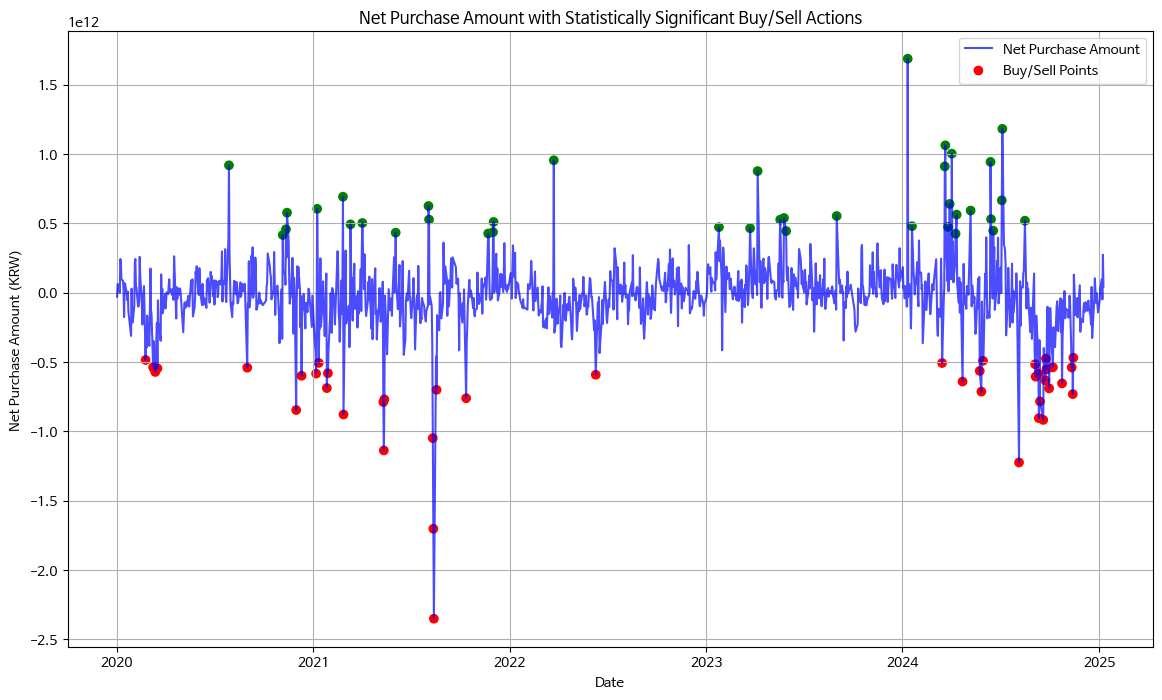

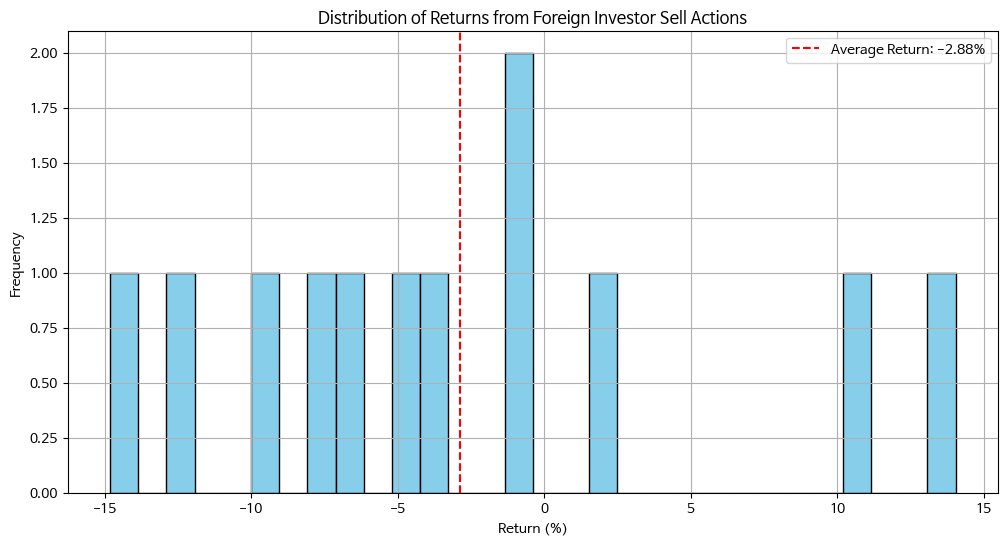

Average Return: -2.8794104206293483
Profit-Taking Threshold: 10.613598673300165
Stop-Loss Threshold: -6.642066420664207


In [65]:

# Step 5: 주가 데이터에 Buy/Sell 지점 표시한 그래프 생성
plt.figure(figsize=(14, 8))
plt.plot(combined_data.index, combined_data['Net Purchase Amount'], label='Net Purchase Amount', color='blue', alpha=0.7)
plt.scatter(results.index, results['Net Purchase Amount'], c=np.where(results['Action'] == 'Buy', 'green', 'red'), marker='o', label='Buy/Sell Points')
plt.title('Net Purchase Amount with Statistically Significant Buy/Sell Actions')
plt.xlabel('Date')
plt.ylabel('Net Purchase Amount (KRW)')
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Returns 계산 및 분포 그래프 생성
buy_price = None
holding_periods = []
returns = []
entry_dates = []
exit_dates = []

for date, row in results.iterrows():
    if row['Action'] == 'Buy' and buy_price is None:
        buy_price = combined_data.loc[date]['종가']
        entry_dates.append(date)
    elif row['Action'] == 'Sell' and buy_price is not None:
        sell_price = combined_data.loc[date]['종가']
        return_pct = ((sell_price - buy_price) / buy_price) * 100
        holding_period = (date - entry_dates[-1]).days
        holding_periods.append(holding_period)
        returns.append(return_pct)
        exit_dates.append(date)
        buy_price = None

# Returns 분포 시각화
plt.figure(figsize=(12, 6))
plt.hist(returns, bins=30, color='skyblue', edgecolor='black')
plt.axvline(np.mean(returns), color='red', linestyle='dashed', linewidth=1.5, label=f'Average Return: {np.mean(returns):.2f}%')
plt.title('Distribution of Returns from Foreign Investor Sell Actions')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: 평균 수익률, 익절 및 손절 기준 계산
average_return = np.mean(returns)
profit_threshold = np.percentile([r for r in returns if r > 0], 50)  # Median of positive returns (profit-taking)
loss_threshold = np.percentile([r for r in returns if r < 0], 50)    # Median of negative returns (stop-loss)

# 결과 출력
print("Average Return:", average_return)
print("Profit-Taking Threshold:", profit_threshold)
print("Stop-Loss Threshold:", loss_threshold)


# Step 7: 최근 매수 종가 기준 상승/손실률 계산
if results['Action'].iloc[-1] == 'Buy':
    latest_buy_price = combined_data.loc[results.index[-1]]['종가']
    current_price = combined_data.iloc[-1]['종가']
    profit_or_loss = ((current_price - latest_buy_price) / latest_buy_price) * 100
    print(f"Latest Buy Price: {latest_buy_price:.2f} KRW")
    print(f"Current Price: {current_price:.2f} KRW")
    print(f"Profit/Loss since last Buy: {profit_or_loss:.2f}%")




# 개선된 버전 (2024-01-14)

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from pykrx import stock

# Step 1: 데이터 가져오기
ticker = "005930"  # 삼성전자
start_date = "20200101"
end_date = "20250114"

# 종가, 외국인 보유 비중, 외국인 순매수 거래대금 가져오기
price_data = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)['종가']
foreign_holding_data = stock.get_exhaustion_rates_of_foreign_investment_by_date(start_date, end_date, ticker)['지분율']
net_buy_sell_data = stock.get_market_trading_value_by_date(start_date, end_date, ticker)['외국인합계']

# Step 2: 데이터프레임 병합
combined_data = pd.concat([price_data, foreign_holding_data, net_buy_sell_data], axis=1)
combined_data.columns = ['Close Price', 'Foreign Holding %', 'Net Buy/Sell (Foreigners)']

# Step 3: 인덱스를 날짜 형식으로 변환
combined_data.index = pd.to_datetime(combined_data.index)

# Step 4: 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_data['Net Buy/Sell (Foreigners)'].values.reshape(-1, 1))
y_scaled = scaler.fit_transform(combined_data['Close Price'].values.reshape(-1, 1))

# Step 5: Linear Regression to find the impact of net buy/sell on stock price
reg_model = LinearRegression()
reg_model.fit(X_scaled, y_scaled)
slope = reg_model.coef_[0][0]
intercept = reg_model.intercept_[0]

# Step 6: R² 값 계산
y_pred = reg_model.predict(X_scaled)
r2 = r2_score(y_scaled, y_pred)

# Step 7: Plotting the regression analysis
plt.figure(figsize=(14, 7))
plt.title("Stock Price vs Foreign Net Buy/Sell (Scaled Linear Regression)")
plt.scatter(X_scaled, y_scaled, alpha=0.5, label="Data Points")
plt.plot(X_scaled, y_pred, color="red", label=f"Linear Fit: y = {slope:.4f}x + {intercept:.4f}\nR² = {r2:.4f}")
plt.xlabel("Net Buy/Sell (Foreigners) (Scaled)")
plt.ylabel("Close Price (Scaled)")
plt.legend()
plt.grid(True)
plt.show()

# Step 8: AutoCorrelation Function (ACF)
acf_values = acf(combined_data['Net Buy/Sell (Foreigners)'], nlags=30)

# Step 9: Plotting ACF
plt.figure(figsize=(14, 7))
plt.title("AutoCorrelation of Foreign Net Buy/Sell (ACF)")
plt.bar(range(len(acf_values)), acf_values, color='blue', alpha=0.6)
plt.xlabel("Lag")
plt.ylabel("ACF Value")
plt.grid(True)
plt.show()


JSONDecodeError: Expecting value: line 1 column 1 (char 0)